### COMP 473 Group Project

#### Facial Expression Recognition: 6-Class Classification

##### Importing main libraries used

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import PIL
import pandas as pd

classes = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

#### Training Metrics Graph
Automatically update loss and accuracy of training and validation set and display the graph as the model gets trained

In [2]:
from IPython.display import clear_output


class PlotTrain(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        #To plot the graph
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

        axs[i].legend()
        axs[i].grid()
        plt.tight_layout()
        plt.show()

In [3]:
def myClassType(myClass):
    return_class = []
    for i in myClass:
        if (i == 0):
            return_class += ['anger']
        if (i == 1):
            return_class += ['disgust']
        if (i == 2):
            return_class += ['fear']
        if (i == 3):
            return_class += ['happy']
        if (i == 4):
            return_class += ['sadness']
        if (i == 5):
            return_class += ['surprise']
    return return_class

### Sample image from each class

S131_010_000000152.4.png
S136_005_00000007-5.7.png
S037_006_00000021-7.2.png
S131_003_000000205.4.png
S119_003_00000021-2.4.png
S125_007_0000000910.2.png


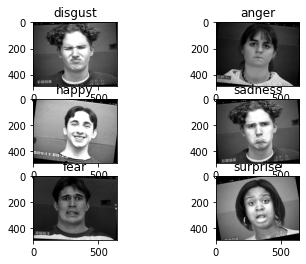

In [4]:
path = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+_Complete'

for index, directory_name in enumerate(os.listdir(path)):
    joined_directory = os.path.join(path, directory_name)
    sample_image = random.choice(os.listdir(joined_directory))
    print(sample_image)
    image = PIL.Image.open(os.path.join(joined_directory, sample_image)).convert('I')
    plt.subplot(3, 2, index + 1)
    plt.title(directory_name)
    plt.imshow(image)

### Printing of dataframe to show matching labels

In [5]:

#load all the data
def get_all_file_paths(path):
    all_filenames = []
    for root, subdirs, files in os.walk(path):
        for name in files:
            absolute_filepath = os.path.join(root, name)
            relative_file_path = os.path.join(os.path.basename(root), name)
            all_filenames.append(relative_file_path)
            # print(name)
    return all_filenames


def get_label(file_name):
    if 'angry' in str(file_name):
        return 0
    if 'disgust' in str(file_name):
        return 1
    if 'fear' in str(file_name):
        return 2
    if 'happy' in str(file_name):
        return 3
    if 'sad' in str(file_name):
        return 4
    if 'surprise' in str(file_name):
        return 5


categories = []

filenames = get_all_file_paths(path)
# use list() to show all the values inside a list
# print(list(filenames))
# randomize the files
random.shuffle(filenames)
for filename in filenames:
    categories.append(get_label(filename))
# print(list(categories))

# join the filename and categories list together

dataframe = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


<AxesSubplot: >

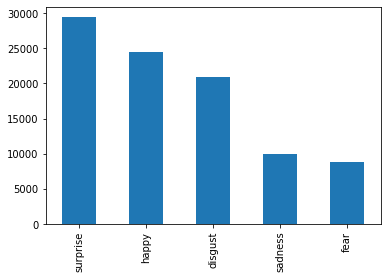

In [6]:
dataframe["category"] = dataframe["category"].replace(
    {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sadness', 5: 'surprise', })
dataframe['category'].value_counts().plot.bar()

### Training and Testing Models

Code implementation for each modes is the same throughout the experiment.
<br>Thus, only the first model contains information and comments about the implmentation.
<br>Simply need to change the variables 'path', 'MODEL_NAME' for each models
<br>
<br>To avoid overfitting, early stopping feature is implemented to stop the training (TO DO)

## ====No Pre-Processing=====

Training and Testing on the basic model with Dataset1

In [7]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CK_s1'
dataset_2_folder_name = 'CK_s2'
dataset_3_folder_name = 'CK_s3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

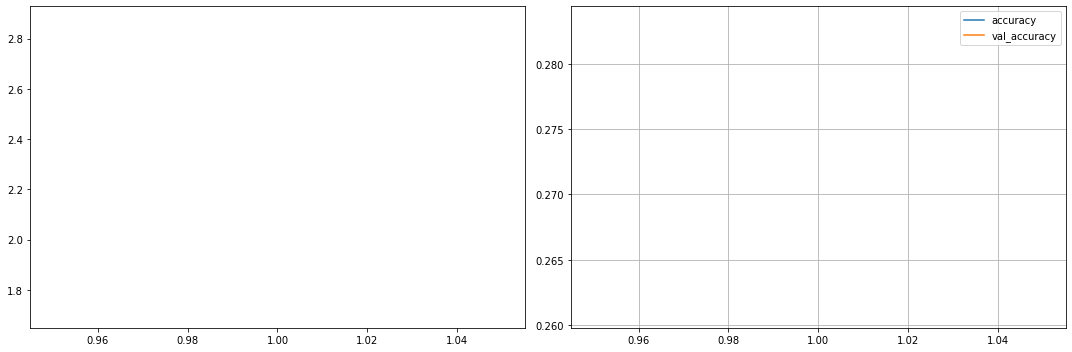

142/142 [==============================] - 49s 331ms/step - loss: 2.8699 - accuracy: 0.2609 - val_loss: 1.7076 - val_accuracy: 0.2833
Epoch 2/15
 53/142 [==========>...................] - ETA: 25s - loss: 1.6557 - accuracy: 0.3391

KeyboardInterrupt: 

In [8]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
# prints summary of our model.
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

# monitor	Quantity to be monitored.
# patience	Number of epochs with no improvement after which training will be stopped.
# verbose	Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
# mode	One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = "1_basic_d1.h5"

test_dir = os.path.join(project_folder_name, folder_type[1])
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset2

In [ ]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])
NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_basic_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

In [ ]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_basic_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### ====Image Cropping====

Training and Testing on the image cropping model with Dataset1

In [ ]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Cropping_1'
dataset_2_folder_name = 'CKD_Cropping_2'
dataset_3_folder_name = 'CKD_Cropping_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

In [ ]:


path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_crop_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the image cropping model with Dataset2

In [ ]:

path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_crop_d2.h5'

#Fetch testing data from the dataset2
test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

In [ ]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_crop_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## ====Intensity Normalization====

Training and Testing on the Intensity Normalization model with Dataset1

In [ ]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_IntentNorm_1'
dataset_2_folder_name = 'CKD_IntentNorm_2'
dataset_3_folder_name = 'CKD_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

In [ ]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Intensity Normalization model with Dataset2

In [ ]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

We are here

Training and Testing on the Intensity Normalization model with Dataset3

In [ ]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## ====Image Cropping and Intensity Normalization====

Training and Testing on the Cropping and Intensity Normalization model with Dataset1

In [ ]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Crop_IntentNorm_1'
dataset_2_folder_name = 'CKD_Crop_IntentNorm_2'
dataset_3_folder_name = 'CKD_Crop_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

In [ ]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d1.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset2

In [ ]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d2.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset3


In [ ]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_CR_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

In [ ]:
# WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()